In [1]:
#Importing Libraries and estalbishing connectuon to database
# univariate lstm example

import numpy as np
import sqldf
import pandas as pd
import cx_Oracle as cxo
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

start_time = dt.today()
print('\nSTART TIME : ', start_time.time(),'\n')

conn = cxo.connect("GIS_IN","GIS_IN", "172.29.10.10:1521/GISIN")

#this is the forecasted dataset
df = pd.read_sql("select * from IN_PART_R where company_code='95004-KR1' and PART_NO = '25A-AR40-04-B' order by 1,2", con=conn)

from sklearn.impute import KNNImputer
df_t = df[:24]
imputer = KNNImputer(n_neighbors = 4, weights = "uniform")
df_t['QTY'] = imputer.fit_transform(df_t[['QTY']])
df_t.set_index('PERIOD',inplace= True)


# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix:end_ix+1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# choose number of time stamps(we can take any value)
n_steps = 3
# split into samples
X, y = prepare_data(df_t['QTY'], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

#BUILDING LSTM MODEL
# define model
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=700, verbose=1)

# demonstrate prediction for next 10 days
x_input = np.array(df_t['QTY'][-3:])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<12):
    
    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    
end_time = dt.today()
print('\nEND_TIME : ', end_time.time(),'\n')
print('\nTOTAL SCRIPT RUNTIME : ', (end_time-start_time))

C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr


START TIME :  09:49:25.521783 



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAPE: 1.084
MSE: 1544.451
MAE: 31.261
RMSE: 39.300


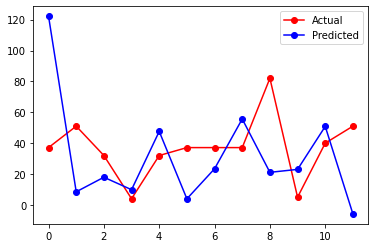

In [22]:
#For calculating Mape and MSE

df_act = df[24:]
df_act = df_act[['PERIOD','QTY']]
imputer = KNNImputer(n_neighbors = 4, weights = "uniform")
df_act['QTY'] = imputer.fit_transform(df_act[['QTY']])
df_act.set_index('PERIOD',inplace= True)

y_true = df_act['QTY'].values
y_pred = lst_output
MAPE = mean_absolute_percentage_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true,y_pred)
rmse = math.sqrt(mse)
print('MAPE: %.3f' % MAPE)
print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
# plot expected vs actual
plt.plot(y_true, marker='o', color='red',label = 'Actual')
plt.plot(y_pred, marker='o', color='blue',label = 'Predicted')
pyplot.legend()
pyplot.show()

In [26]:
#Complete function for LSTM SO THAT IT CAN BE RUN FOR ALL PARTS 


def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix:end_ix+1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


def RNN(df):
    import warnings
    import math
    from pandas import read_csv
    from pandas import to_datetime
    import numpy as np
    import os 
    import numpy as np
    from keras.models import Sequential
    from keras.layers import LSTM
    from keras.layers import Dense, Dropout
    import pandas as pd
    from matplotlib import pyplot as plt
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns
    warnings.filterwarnings("ignore")
    PART_N = list(df['PART_NO'].unique())
    a = pd.DataFrame()
    for i in range(0,len(PART_N)):
        df_1 = df[df['PART_NO'] == PART_N[i]]
        df_1['PERIOD'] = pd.to_datetime(df_1['PERIOD'], format= '%Y%m')
        df_1 = df_1[['PERIOD','QTY']]
        # choose a number of time steps
        n_steps = 3
        # split into samples
        X, y = prepare_data(df_1['QTY'], n_steps)
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        # define model
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(X, y, epochs=800, verbose=0)
        x_input = np.array(df_1['QTY'][-3:])
        temp_input=list(x_input)
        lst_output=[]
        j=0
        while(i<12):
            if(len(temp_input)>3):
                x_input=np.array(temp_input[1:])
                x_input = x_input.reshape((1, n_steps, n_features))
                yhat = model.predict(x_input, verbose=0)
                temp_input.append(yhat[0][0])
                temp_input=temp_input[1:]
                lst_output.append(yhat[0][0])
                j=j+1
            else:
                x_input = x_input.reshape((1, n_steps, n_features))
                yhat = model.predict(x_input, verbose=0)
                #print(yhat[0])
                temp_input.append(yhat[0][0])
                lst_output.append(yhat[0][0])
                j=j+1
        df_new = pd.DataFrame()
        df_new['QTY'] = lst_output
        df_new['PERIOD'] = pd.date_range(start='01/01/2021', end='12/01/2021',freq = 'MS')
        df_new['CODE'] = PART_N[i]
        df_new1 = df_new[['PERIOD','CODE','QTY']] 
        a = pd.concat([a,df_new1])
    a.to_csv(r'C:/Users/SMC ANALYTICS 1/Desktop/SANDEEP/Time Sales Forecasting/RNNLSTM_1.csv', index = False)   

In [8]:
def RNN(df):
    import warnings
    import math
    import rpy2.robjects as robjects
    # import R packages
    from rpy2.robjects.packages import importr
    imputeTS = importr('imputeTS') 
    kalman_StructTs = robjects.r['na.kalman']
    kalman_auto_arima = robjects.r['na.kalman']
    from pandas import read_csv
    from pandas import to_datetime
    import numpy as np
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    import numpy as np
    import pandas as pd
    warnings.filterwarnings("ignore")
    PART_N = list(df['PART_NO'].unique())
    a = pd.DataFrame()
    for i in range(0,len(PART_N)):
        df_1 = df[df['PART_NO'] == PART_N[i]]
        df_1['PERIOD'] = pd.to_datetime(df_1['PERIOD'], format= '%Y%m')
        df_1 = df_1[['PERIOD','QTY']]
        this_value = np.ndarray.tolist(df_1['QTY'].values)
        this_value = robjects.FloatVector(this_value)
        df_1['QTY'] = kalman_StructTs(this_value, model = "StructTS")
        # choose a number of time steps
        n_steps = 3
        # split into samples
        X, y = prepare_data(df_1['QTY'], n_steps)
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        # define model
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(X, y, epochs=300, verbose=0)
        x_input = np.array(df_1['QTY'][-3:])
        temp_input=list(x_input)
        lst_output=[]
        j=0
        while(j<12):
            if(len(temp_input)>3):
                x_input=np.array(temp_input[1:])
                x_input = x_input.reshape((1, n_steps, n_features))
                yhat = model.predict(x_input, verbose=0)
                temp_input.append(yhat[0][0])
                temp_input=temp_input[1:]
                lst_output.append(yhat[0][0])
                j=j+1
            else:
                x_input = x_input.reshape((1, n_steps, n_features))
                yhat = model.predict(x_input, verbose=0)
                #print(yhat[0])
                temp_input.append(yhat[0][0])
                lst_output.append(yhat[0][0])
                j=j+1
        df_new = pd.DataFrame()
        df_new['QTY'] = lst_output
        df_new['PERIOD'] = pd.date_range(start='01/01/2021', end='12/01/2021',freq = 'MS')
        df_new['COMPANY_CODE'] = PART_N[i]
        df_new1 = df_new[['PERIOD','COMPANY_CODE','QTY']] 
        a = pd.concat([a,df_new1])
    return (a)